# Robustness

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm import tqdm
from itertools import product
from copy import deepcopy

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

import utility as uti

import seaborn as sns
sns.set_theme(style='darkgrid')

In [2]:
%%capture
%run ./german.ipynb

In [3]:
seed = 2021   # Keep results consistent through testing
NEW = False   # True : recreate all data (can be very long), False : read data from disk

# Il est plutôt facile de faire dire ce que l'on veut à un modèle

## Définition de *robustness*

Le concept de *robustness* est une notion importante en statistique et en économétrie qui existait déjà lorsque les modèles d'apprentissage machines sont apparus. Il est défini de la manière suivante :

Un modèle est robuste s'il n'est pas affecté par la présence de valeurs aberrantes ou de déviation des hypothèses sur les données de départ.

Cette définition a été contrainte d’évoluer afin de s’adapter à la nouvelle manière de mettre les modèles à jour. Si auparavant les modèles étaient entraînés au sein d'un laboratoire avec un grand contrôle des données d'entraînement, aujourd'hui les modèles se mettent à jour constamment et de façon automatisée. Cette automatisation induit une perte de contrôle stricte des données et une nouvelle vulnérabilité qui rendent nécessaire l’ajout d'un nouveau rôle pour la *robustness*.

En apprentissage statistique, un modèle est dit robuste s'il n'est pas affecté par des données qui ne sont pas similaires à celles sur lesquelles le modèle s'est entraîné.

Dans la plupart des cas, ces données sont spécifiquement construites par une entité malveillante dans le but de grandement impacter les résultats du modèle de départ. Cette nouvelle notion de *robustness* est pour cela nommée *adverserial robustness* (*adverserial* dans le sens conflictuel).

Il existe trois catégorisations des attaques d'*adverserial robustness* qui répondent chacune à une question :
 - Qu’est-ce qui est attaqué ?
 - Comment est-il attaqué ?
 - Pourquoi est-il attaqué ?
 
Tout comme les attaques de *privacy*, les attaques d'*adverserial robustness* sont catégorisés dans un premier temps entre les attaques sur modèle boîte blanche et sur modèle boîte noire. Un modèle boîte blanche est un modèle dont on peut prévoir le fonctionnement interne car on connaît toutes ces caractéristiques des éléments qui le composent. ([white box](https://fr.wikipedia.org/wiki/Bo%C3%AEte_blanche)) En apprentissage statistique cela correspond à un modèle où l'on a accès aux données d'entraînement et de test, à la structure, aux coefficients et toute autre information permettant de reproduire le modèle à l'identique. Au contraire, le modèle boite noire est un modèle pour lequel on a aucune visibilité sur le fonctionnement interne. Dans le cas du modèle boîte noire, on a ainsi seulement accès aux entrées et sorties du modèle. En apprentissage statistique le modèle de boîte noire correspond à la majorité des modèles commerciaux qui fonctionnent sous forme d'API (*Application Programming Interface*). L'utilisateur de ces modèles envoie des données au modèle en question et ne récupère que la sortie. Les attaques *adverserial robustness* contre des modèles boîtes blanches sont très faciles à mettre en œuvre et ces modèles sont très difficilement protégeables. Cette raison motive l'existence des modèles en boîte noire qui sont des modèles pouvant espérer être robustes aux attaques adversaires.

### Qu’est-ce qui est attaqué ?
Il existe différents types d’attaque selon la partie du modèle qui est ciblée. Les attaques d'évasion (*evasion attacks*) qui ajustent les données de test, les attaques d'empoisonnement (*poisining attacks*) qui ajustent les données d’entraînement, et les attaques d'exploration (*exploration attacks*) qui questionnent le modèle boite noire pour faire de la rétro-ingénierie, sont les trois grandes familles d’attaque.

### Comment il est attaqué ?
Les façons selon lesquelles le modèle est attaqué dépendent grandement de la quantité et du type d'information dont l'adversaire dispose.

Avant l'entraînement :
Selon s'il peut modifier la base d'entraînement ou uniquement ajouter de nouvelles données à celle-ci, l’adversaire pourra effectuer une *data modification* ou une *data injection*. Si en revanche il a accès au modèle, il pourra corrompre directement la logique de celui-ci (*logic corruption*).

Après l'entraînement :
Deux types d’attaque existent :
 - *Adaptative attacks* : Ces attaques consistent à modifier les entrées en multipliant les requêtes jusqu'à ce que la sortie convienne. On cherche alors à obtenir une sortie spécifique ou à créer des entrées sur lesquels le modèle se trompe.
 - *Non-adaptative attacks* : La modification des entrées se fait grâce à une connaissance préalable d'informations sur les données d'entraînement dans le même but que pour les attaques adaptatives.
 
### Pourquoi il est attaqué ?
La raison d'une attaque appartient à l’une des quatre grandes familles suivante:
 - Réduction de la qualité générale de prédiction d'un modèle
 - Engendrer une erreur de classification sur toutes les entrées
 - Engendrer une erreur de classification sur toute une classe d'entrée
 - Engendrer une erreur de classification sur une entrée précise

[source](https://arxiv.org/pdf/1810.00069.pdf)

Dans la suite nous allons mettre en oeuvre deux attaques :
 - une évasion contre un modèle boîte noire de type attaque adaptative ayant pour but d'engendrer une erreur de classification sur une entrée précise.
 - un empoisonnement contre un modèle boîte noire de type *data injection* ayant pour but d'engendrer une erreur de classification sur une entrée précise.


# Description générale des différentes attaques et implémentation

Le cas de figure est le suivant, on suppose que notre banque utilise le modèle de régression logistique développé dans l'article d'introduction. Celui-ci utilise une base d'entraînement de 800 personnes et les classe en fonction de leur capacité de remboursement (0 : capable de rembourser, 1 : incapable de rembourser). Dans cette optique, on peut tout à fait concevoir qu'un individu apprenant que son prêt a été refusé par le modèle va chercher à contourner celui-ci. Nous présentons ici deux cas de figure.


## Évasion

On se place dans une situation où l'individu est en mesure de questionner le modèle sans contrainte. On peut imaginer un problème de sécurité qui cause la divulgation du modèle, l'utilisation par la banque d'un modèle open source ou l'utilisation d'un modèle annexe que l'on aurait calibré grâce à la méthode de *model extraction* (cf. l'article *privacy*). Le type d'attaque utilisé est une attaque adaptative donc on va chercher les variables les plus falsifiables et les modifier jusqu'à ce que l'individu refusé soit accepté.

En observant les différentes variables on remarque que très peu d’entre elles peuvent être modifiées sans que cela soit vérifiable. La cause à cela est qu’il s’agit d’une base de données pour crédit, aussi les informations du client sont examinées avec précaution.
On peut néanmoins supposer que les deux variables suivantes peuvent être falsifiées sans difficulté.
 - purpose : correspond à la finalité du prêt
 - personal_status : la condition de vie en couple

L’attaque commence par choisir une personne dont le prêt a été refusé pour jouer le rôle d'adversaire :


In [4]:
idx_default = np.where(logreg.predict(X_test))[0]

np.random.seed(seed)
adv_ind = X_test.iloc[np.random.choice(idx_default)]
adv_ind

account_check_status                                                     < 0 DM
duration_in_month                                                            24
credit_history                         existing credits paid back duly till now
purpose                                                               car (new)
credit_amount                                                              1207
savings                                                            ... < 100 DM
present_emp_since                                                  ... < 1 year
installment_as_income_perc                                                    4
sex                                                                      female
personal_status                                                        divorced
other_debtors                                                              none
present_res_since                                                             4
property                      if not A12

Notre individu ci-dessus est une femme étrangère divorcée de 24 ans avec une personne à sa charge qui n'a pas remboursé toutes ces dettes. Elle se voit refuser son crédit pour une nouvelle voiture et cherche donc à modifier les variables difficilement vérifiables (ie `purpose` et `personal_status`) afin d’avoir une chance que son prêt soit accepté. Pour cela, elle utilise une méthode exhaustive en créant toutes les combinaisons possibles avec les variables difficilement vérifiables et les faire tester par le modèle dans l’espoir que l’une d’entre elle lui permette que son prêt soit accepté.

Le modèle de régression logistique attribue un score dans l'intervalle [0,1] à chaque individu puis le place dans l'une des deux classes prêt accordé / prêt refusé en fonction du score obtenu. Aussi un score supérieur à 0.5 placera l'individu dans la catégorie 1 : prêt refusé, tandis qu'un score inférieur ou égal à 0.5 placera l'individu dans la catégorie 0 : prêt accepté.

In [5]:
# variables that are difficults to verify
var_columns = ['purpose', 'personal_status']

# variables that are hard to falsify (all the other)
fix_columns = [x for x in X.columns if x not in var_columns]

# catesian product of all possibilities from variables that can change
all_values = [X[col].unique() for col in var_columns]
prod = list(product(*all_values))   

# all possible entries that can be generated
all_adv_ind = pd.DataFrame([adv_ind[fix_columns].tolist() + list(p) for p in prod],
                      columns=fix_columns + var_columns)
all_adv_ind = all_adv_ind[X.columns]

# predict the score for all entries
all_adv_ind['proba'] = logreg.predict_proba(all_adv_ind)[:, 1]

In [6]:
# take only the entries that gets a 0
valid_adv_ind = all_adv_ind[all_adv_ind.proba < 0.5]

# calculate the number of variables that were changed
nb_diff = []
for i in range(len(valid_adv_ind)):
    val_diff = (valid_adv_ind.iloc[i][var_columns] == adv_ind[var_columns])
    nb_diff += [val_diff.value_counts()[False]]
    
valid_adv_ind = valid_adv_ind.assign(diff = nb_diff)

# take the least change entrie that have the biggest impact
valid_adv_ind.sort_values(by=['diff', 'proba'], inplace=True)
valid_adv_ind.head(3)

,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,sex,personal_status,...,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker,proba,diff
12,< 0 DM,24,existing credits paid back duly till now,car (used),1207,... < 100 DM,... < 1 year,4,female,single,...,24,none,rent,1,skilled employee / official,1,none,yes,0.387855,2
14,< 0 DM,24,existing credits paid back duly till now,car (used),1207,... < 100 DM,... < 1 year,4,female,married,...,24,none,rent,1,skilled employee / official,1,none,yes,0.471957,2


On voit ainsi que modifier les variables `purpose` et `personal_status` suffit pour passer en dessous d'un score de 0.5 faisant ainsi changer la classe de notre individu de 1 à 0 (le prêt est maintenant accepté). Voyons la combinaison de ces variables ayant permis ce changement de classe.

In [7]:
def print_diff(old_comb, new_comb):
    '''Print the difference between two entries'''
    diff_comb = (new_comb != old_comb)
    diff_pd = pd.DataFrame([old_comb[diff_comb], 
                            new_comb[diff_comb]], index=['old', 'new']).transpose()
    
    if diff_pd.empty: raise ValueError
        
    # juste for styling
    max_ind = max([len(x) for x in diff_pd.index])
    max_old = max([len(x) for x in diff_pd.old])
    max_new = max([len(x) for x in diff_pd.new])

    for i in new_comb[diff_comb].index :
        print('{:<{}} : {:<{}} --> {:<{}}'.format(i, max_ind,
                                                  diff_pd.old[i], max_old,
                                                  diff_pd.new[i], max_new))

In [8]:
try:
    print_diff(adv_ind[var_columns], valid_adv_ind.iloc[0][var_columns])
except ValueError:
    print("Aucun changement")

purpose         : car (new) --> car (used)
personal_status : divorced  --> single    


Pour passer à un score de moins de 0.5, il suffit à notre individu de falsifier la raison de son prêt en disant que c'est pour une voiture d'occasion et de dire qu'elle n'a jamais été mariée.

Maintenant que nous avons fait l'étude de cas sur un individu en particulier, nous allons voir comment ce raisonnement se généralise à notre population de test.
On applique la même méthode pour chaque individu qui se voit refuser son crédit et on calcule la probabilité minimale atteignable pour chacun d’entre eux.

In [9]:
def gen_all_ind(df, var_columns):
    # variables that do not change
    fix_columns = [x for x in df.columns if x not in var_columns]

    # catesian product of all possibilities from variables that can change
    all_values = [X[col].unique() for col in var_columns]
    prod = list(product(*all_values))  

    all_inds = []
    for idx, ind in tqdm(df.iterrows()):
        for p in prod:
            all_inds += [list(ind[fix_columns]) 
                         + list(p) 
                         + [idx]]

    column_names = fix_columns + var_columns + ['index_old']
    return pd.DataFrame(all_inds, columns=column_names)

In [10]:
X_default = X_test.iloc[idx_default]
X_default = X_default.assign(old_proba = logreg.predict_proba(X_default)[:, 1])

if NEW:
    old_var = [X_default[name].rename('old_'+name) for name in var_columns]
    X_default = pd.concat([X_default, pd.DataFrame(old_var).transpose()], axis=1)

    all_adv_inds = gen_all_ind(X_default, var_columns)
    
    all_adv_inds['proba'] = logreg.predict_proba(all_adv_inds[X.columns])[:, 1]
    
    np.savez_compressed('data/privacy/all_adv_inds.npz', 
                        data=np.array(all_adv_inds),
                       columns=all_adv_inds.columns)
else:
    file = np.load('data/privacy/all_adv_inds.npz', allow_pickle=True)
    all_adv_inds = pd.DataFrame(file['data'], columns=file['columns'])


# fonction that takes the minimum proba of a group of entries 
def min_proba(df):
    return df.sort_values('proba').head(1).proba

proba_min = all_adv_inds.groupby('index_old').apply(lambda df: min_proba(df))
X_default = X_default.assign(proba_min = proba_min.droplevel(1))

print('Default label : {}'.format(len(X_default)))
print('Change to no-default : {}'.format(len(X_default[X_default.proba_min < 0.5])))

Default label : 49
Change to no-default : 46


Sur les 49 personnes labellisées comme incapable de rembourser dans la base de données de test, l'évasion à permis de changer la labellisation pour 46 d'entre eux. Autrement dit, 94% des personnes dans la base de test dont le prêt s’est vu refusé peuvent se faire accepter en changeant seulement la raison du prêt et/ou leur statut de relation. Ceci est très problématique du point de vue de la banque. Voyons maintenant la distribution du gain de score obtenu par l'évasion.

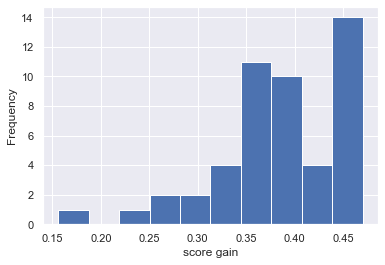

In [11]:
(X_default.old_proba - X_default.proba_min).plot.hist()
plt.ylabel('Frequency')
plt.xlabel('score gain')
plt.show()

On voit sur ce graphique qu’une majorité d'individus voient leur score diminuer d'au moins 0.35 lorsqu'ils changent les deux paramètres falsifiables. Notre modèle n'est ainsi pas robuste car il ne prend pas en compte que l'agent peut être malveillant.

On remarque tout de même qu'une trentaine de personnes ne sont pas capables de modifier le label attribué (1 : le prêt est refusé) en falsifiant ces deux variables. La partie suivante va démontrer que si l'agent est capable de rajouter des éléments dans la base d'entraînement (*data augmentation*) alors tous ces individus peuvent voir leur prêt se faire accepter.

---
[RAPPORT]

#### Généralisation de l'attaque

Pour résumé le principe de cette attaque est le suivant :

Sous l'hypothèse que l'on ai accès à la sortie du modèle on génère toutes les combinaisons de variables falsifiables et on retient celles qui permettent un changement de classification.

Bien que cette exemple soit trivial il contient les principes généraux. Malheureusement notre méthode ne peut pas s'étendre à des modèles qui ont par exemple des variables continues comme variables falsifiables ou bien un très grand nombre de variables falsifiables.

C'est le cas des modèles de visions qui traitent des images. Les images sont des objets à très grandes dimension et facilement modifiables.

**Exemple de deux images semblables mais différentes**

Pour comprendre comment généraliser cette attaque à des modèles plus complexes nous définir une attaque d'évasion mathématiquement. Il est tout à fait possible de sauter cette partie.

([source](https://adversarial-ml-tutorial.org/introduction/))

Comme la méthode s'inspire de la manière dont sont entraînés les modèles il est judicieux de reprendre les définition classique de l'apprentissage statistique.

On note notre modèle $h_{\theta} : \mathcal{X} \rightarrow \mathbb{R}^k$, c'est un mapping de l'espace de départ, ici les variables de l'individu, à un vecteur réel de $k$ dimensions, ici un vecteur de taille 2 pour la classe 0 et la classe 1. Le $\theta$ représente les différents paramètres de notre modèle, ici les coefficients de la régression. C'est ce qui va être optimisé lorsque l'on va entraîner notre modèle.

La fonction de perte $l : \mathbb{R}^k \times \mathbb{Z} \rightarrow \mathbb{R}_+$ est définie comme le mapping du couple de la prédiction et de la vrai valeur de label vers un réel positif. La notation
$$
\ell(h_{\theta}(x)),y)
$$
avec $x \in \mathcal{X}$ l'entrée et $y \in \mathcal{Z}$ la vrai classe exprime la perte du modèle pour sa prédiction à partir de $x$ sachant que la vrai classe est $y$. 

Le principe fondamentale de l'apprentissage statistique est la minimisation de la fonction perte. Le problème est alors un problème d'optimisation et s'écrit :
$$
\min_{\theta} \frac{1}{m} \sum^m_{i=1} \ell(h_{\theta}(x_i)),y_i)
$$
Il est typiquement résolut par une descente de gradient, pour chaque minibatch $\mathcal{B} \subseteq \{1, ..., m\}$ on calcule le gradient de notre fonction perte par rapport à nos paramètres $\theta$ et on le modifie légèrement en la direction opposé du gradient 
$$
\theta:=\theta-\frac{\alpha}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \nabla_{\theta} \ell\left(h_{\theta}\left(x_{i}\right), y_{i}\right)
$$

avec $\alpha$ le pas, et on recommence sur différente minibatch jusqu'à la convergence de nos paramètres. Le terme central est le gradient $\nabla_{\theta} \ell\left(h_{\theta}\left(x_{i}\right), y_{i}\right)$. Pour les modèle complexe celui-ci se calcul par *backprobagation* **ref** en appliquant la méthode de différentiation automatique. La beauté de cette méthode est qu'elle ne limite pas la différentiation de la fonction perte par rapport à $\theta$ et on peut très bien la calculer par rapport à une entrée $x_i$. 
La quantité calculée sera alors l'impacte d'un changement de l'entrée sur la fonction perte.

On va donc utiliser cette information pour créer une entrée qui modifie la perte, on veut résoudre
$$
\max_{\hat{x}} \ell(h_{\theta}(\hat{x}), y)
$$
où $\hat{x}$ correspond à notre entrée falsifiée. On ne peut pas prendre comme espace d'optimisation l'ensemble de départ $\mathcal{X}$ car il y a des entrées qui n'ont évidemment pas la même labellisation que $x$. On va donc contraindre $\hat{x}$ pour qu'il soit le plus proche possible de $x$. On formalise généralement cette notion par une perturbation $\delta$ et on optimise par rapport à cette perturbation
$$
\max_{\delta \in \Delta} \ell(h_\theta(x+\delta), y)
$$
avec $\Delta$ qui représente un ensemble de perturbation permises. Dans notre exemple on défini $\Delta$ comme l'ensemble des combinaisons des variables que l'on considère comme falsifiable mais dans un modèle de vision cet ensemble est plus difficile à définir car on aimerait que toutes perturbations qui ne 'modifirait' pas l'image pour un individu (ex: rotation, modification de quelques pixels, ajout de grain, ...) soit permises.

Dans notre exemple nous n'avons pas eu besoin de calculer le gradient car comme l'espace $\Delta$ est discret et n'est pas très grands on peut se permettre de tester toutes les possibilités. De plus nous avons ici que qu'une attaque de *missclassification* notre but étant juste d'avoir une entrée qui donne une sortie différente de l'entrée non perturbée. Pour notre exemple cela est suffisant car il n'y a que deux classes : 0 ou 1. Donc trouver cette entrée pour un individu à qui on a refusé son prêt c'est également trouver l'entrée qui donne spécifiquement le 1 pour cette individu. Mais généralement on ne se trouve pas dans ce cas de figure et une attaque de *missclassification* n'est pas suffisant pour choisir la sortie de l'entrée perturbée. Pour cela on une simple variante : *targeted attacks*

Au lieu de maximiser la perte de la classe de départ on va également minimiser la perte de la classe cible. Cela revient à résoudre le programme d'optimisation 
$$
\underset{\delta \in \Delta}{\operatorname{max}}\left(\ell\left(h_{\theta}(x+\delta), y\right)-\ell(h_{\theta}(x+\delta), y_{\text {target }})\right)
$$

---

### Poisoning

On se place cette fois dans une situation un peu moins probable où l'adversaire peut ajouter des éléments dans la base de données d'entraînement. On peut néanmoins imaginer un complice dans le département informatique qui aurait accès à la base et qui voudrait assurer un prêt pour l'adversaire. On ne suppose pas ici de modification des éléments existants (ce qui serait une attaque par *data modification*) mais bien juste l'ajout d’éléments à la base de données (*data injection*).

Nous allons voir qu'avec un petit nombre d'ajouts on peut faire passer un individu de 1 (défaut) à 0, cette situation étant particulièrement intéressante pour les individus pour qui l'évasion n'a pas été suffisante. Commençons par choisir un individu au hasard parmi les personnes refusées après la tentative d'évasion.


In [12]:
X_poison = X_default[X_default.proba_min >= 0.5]
idx_poison = X_poison.index

np.random.seed(seed)
adv_ind = X.loc[[np.random.choice(idx_poison)]]
adv_ind.iloc[0]

account_check_status                                          0 <= ... < 200 DM
duration_in_month                                                            36
credit_history                                  delay in paying off in the past
purpose                                                               car (new)
credit_amount                                                              7432
savings                                                            ... < 100 DM
present_emp_since                                            1 <= ... < 4 years
installment_as_income_perc                                                    2
sex                                                                      female
personal_status                                                        divorced
other_debtors                                                              none
present_res_since                                                             2
property                      if not A12

Notre individu (815) est cette fois-ci une femme de 54 ans, seul, qui a eu du mal à payer ses crédits passés. C'est une travailleuse étrangère qui demande un peu plus de 7400 DM pour une voiture neuve. Les attaques d'évasion ne sont pas suffisantes pour qu’un prêt soit accordé à cette personne. Dans la suite, nous travaillons avec les données originelles de cet individu (les attaques d’évasions ont été annulées) afin de voir si le *poisoning* seul suffit à renverser la tendance.

Pour cette attaque, on ajoute 5 fois la ligne de l'individu 815 avec comme label 0 dans les données d'entraînement du modèle. Cela consiste en réalité à rentrer 5 fois le profil de l’individu en stipulant que le prêt a été accordé toutes ces fois afin de biaiser le modèle. On entraîne alors le modèle sur cette nouvelle base de données et on regarde les changements obtenus concernant la prédiction du nouveau modèle ainsi que l’impact que ce changement a eu sur les différentes métriques. Le but est alors de diminuer le score de l’individu 714 sans pour autant modifier en profondeur le modèle.

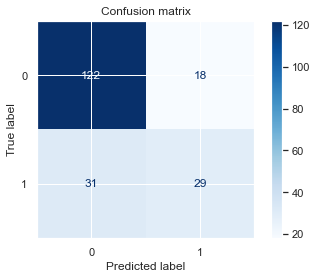

       Sensitivity  Specificity   Precision     Accuracy  
poison     0.87         0.48         0.62         0.76    
  base     0.87         0.48         0.62         0.76    


In [13]:
# Number of time the line will be added to the training set
n = 5

# Adding the lines to the training set
X_train_pois = X_train.append([adv_ind]*n, ignore_index=True)
y_train_pois = pd.Series(list(y_train) + [0]*n)

# Seeing metrics for the new model train on the poison training set
logreg_pois = model.fit(X_train_pois, y_train_pois)
uti.mesure_clas_list([logreg_pois, model], X_test, y_test, ['poison', 'base'])

In [14]:
old_score = logreg.predict_proba(adv_ind)[0,1]
new_score = logreg_pois.predict_proba(adv_ind)[0,1]
print(f'{old_score:.3f} --> {new_score:.3f}')

0.858 --> 0.634


On a une nette amélioration du score de l'individu 815 et comme le montre la matrice de confusion qui compare les labels associés au modèle initial à ceux associés au modèle entraîné sur la base de donnée modifiée, la classification des autres individus a été peu impactée. Malgré nos efforts, l'ajout de 5 entrées n'est pas suffisant pour obtenir le changement de label concernant l’individu 815.
Dans ce qui suit, on va chercher le nombre minimum d'ajouts permettant ce changement de classe.

In [15]:
def min_pois(ind, echo=False, X_train=X_train, y_train=y_train):
    n = 0
    X_train_pois = X_train
    y_train_pois = y_train
    
    # if ind is a pd.Series we change it to a pd.Dataframe
    if isinstance(ind, pd.Series):
        ind = ind.to_frame().transpose()
    
    logreg_pois = model.fit(X_train_pois, y_train_pois)
    
    # Adding one by one the same entry until the score is less or equal that 0.5
    while logreg_pois.predict_proba(ind)[0,1] > 0.5:
        n += 1
        X_train_pois = X_train_pois.append([ind], ignore_index=True)
        y_train_pois = pd.Series(list(y_train_pois) + [0])
    
        logreg_pois = model.fit(X_train_pois, y_train_pois)
    
    if echo:
        old_score = logreg.predict_proba(ind)[0,1]
        new_score = logreg_pois.predict_proba(ind)[0,1]

        print(f'{n:>2} : {old_score:.3f} --> {new_score:.3f}')
        uti.mesure_clas_list([logreg_pois, logreg], X_test, y_test, 
                             ['poison', 'base'])
    
    return n

10 : 0.858 --> 0.479


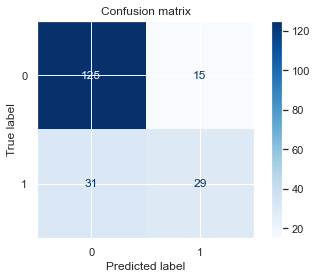

       Sensitivity  Specificity   Precision     Accuracy  
poison     0.89         0.48         0.66         0.77    
  base     0.86         0.50         0.61         0.76    


In [16]:
_ = min_pois(adv_ind, echo=True)

Pour passer de la classe 1 à la classe 0, l'individu 815 a besoin de rajouter 10 fois son entrée associée au label 0. On remarque par ailleurs que faire ces 10 ajouts n’a pas un impact significatif sur les différentes mesures y compris sur les prédictions associées aux autres individus. On peut ainsi considérer que l'attaque est valide.

Nous allons maintenant examiner le nombre d’ajouts nécessaires à l’obtention du prêt concernant les autres individus pour qui l'évasion n'est pas suffisante. 

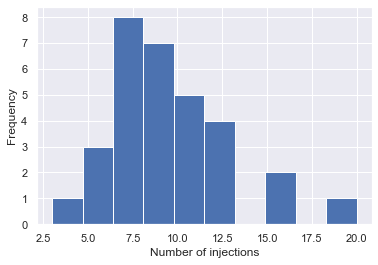

In [17]:
if NEW:
    list_min = X_poison.apply(lambda x: min_pois(x[X.columns]), axis=1)
    np.savez_compressed('data/robustness/list_min.npz', data=list_min)
else:
    list_min = np.load('data/robustness/list_min.npz')['data']
    list_min = pd.Series(list_min)
    
list_min.plot.hist()
plt.xlabel('Number of injections')
plt.show()

Le graphe ci-dessus montre que l’on a une répartition assez étendue allant de 3 à 19 injections nécessaires pour changer la prédiction. 

Sur la base d'entraînement qui contient 800 entrées il peut être difficile de faire passer inaperçu une dizaine de copies de la même entrée. Rien n’empêche ce dernier de coupler les attaques, il peut alors dans un premier temps effectuer une attaque d’évasion afin de faire diminuer son score puis dans un second temps produire une attaque de type poisoning afin que son score passe en dessous de 0,5. Cela permettra notamment d’utiliser moins d’injections et ainsi que l’attaque soit moins repérable.

In [18]:
def min_pois_best_comb(adv_ind, echo=False):
    
    # if ind is a pd.Series we change it to a pd.Dataframe
    if isinstance(adv_ind, pd.Series):
        adv_ind = adv_ind.to_frame().transpose()
    
    adv_ind_all_comb = all_adv_inds[all_adv_inds.index_old == adv_ind.index[0]]
    adv_ind_best_comb = adv_ind_all_comb.sort_values('proba').head(1)[X.columns]

    n = 0
    X_train_pois = X_train
    y_train_pois = y_train
    
    logreg_pois = model.fit(X_train_pois, y_train_pois)
    
    while logreg_pois.predict_proba(adv_ind_best_comb)[0,1] > 0.5:
        n += 1
        X_train_pois = X_train_pois.append([adv_ind_best_comb], ignore_index=True)
        y_train_pois = pd.Series(list(y_train_pois) + [0])
        
        logreg_pois = model.fit(X_train_pois, y_train_pois)
    
    if echo:
        try:
            print_diff(adv_ind.iloc[0], adv_ind_best_comb.iloc[0])
        except ValueError:
            print("Aucun changement")
        
        old_score = logreg.predict_proba(adv_ind_best_comb)[0,1]
        new_score = logreg_pois.predict_proba(adv_ind_best_comb)[0,1]

        print(f'{n:>2} : {old_score:.3f} --> {new_score:.3f}')        
        uti.mesure_clas_list([logreg_pois, logreg], X_test, y_test, 
                             ['poison', 'base'])
    return n

account_check_status : 0 <= ... < 200 DM           --> no checking account                                          
job                  : skilled employee / official --> management/ self-employed/ highly qualified employee/ officer
 1 : 0.550 --> 0.496


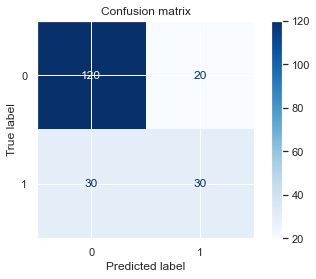

       Sensitivity  Specificity   Precision     Accuracy  
poison     0.86         0.50         0.60         0.75    
  base     0.86         0.50         0.61         0.76    


In [19]:
_ = min_pois_best_comb(adv_ind, True)

Ce couplage d’attaque permet que l’individu 815 soit labellisé 0 avec seulement 1 ajout dans la base de données. Le nombre d’ajouts est ainsi nettement inférieur aux 10 ajouts nécessaires lorsque seule l’attaque *poisoning* est utilisée..
On peut maintenant se pencher sur le cas des autres individus nécessitant une attaque de type *poisoning* (l'attaque d'évasion étant insuffisante).

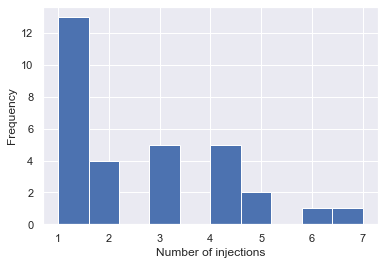

In [20]:
if NEW:
    list_min_best_comb = X_poison.apply(lambda x: min_pois_best_comb(x[X.columns]), axis=1)
    np.savez_compressed('data/robustness/list_min_best_comb.npz', data=list_min_best_comb)
else:
    list_min_best_comb = np.load('data/robustness/list_min_best_comb.npz')['data']
    list_min_best_comb = pd.Series(list_min_best_comb)
    
list_min_best_comb.plot.hist()
plt.xlabel('Number of injections')
plt.show()

On observe alors que pour l'individu le plus difficile à aider, seulement 7 ajouts à la base d'entraînement sont nécessaires pour changer sa labellisation.

Cette étude de cas montre que si l’on ne se préoccupe pas de la *robustness* d’un modèle, les prédictions de celui-ci peuvent être aisément modifiées par un adversaire extérieur.

La faiblesse principale du modèle étudié est qu’il ne prend pas en compte la possibilité que l'agent puisse être malveillant et falsifie son entrée. Dans notre cas, la régression logistique pondère trop grandement des variables qui peuvent être facilement modifiées.
Une solution possible est de retirer les variables falsifiables. Seulement, cette solution implique que les variables puissent être classées de façon binaire dans les classes falsifiables / non falsifiables ce qui n’est pas souvent le cas. De plus, retirer un trop grand nombre d'informations réduit la capacité de prédiction du modèle.
Des solutions plus fines existent et sont présentées dans la partie suivante.


# Mitiger les dégâts

Pour se prémunir des attaques de *robustness* on cherche à rendre notre modèle plus robuste.

Il existe trois grandes familles de méthodes de défense :
 - ***Adverserial training*** : La notion d'adversaire est introduite dans le processus d'entraînement. Il existe plusieurs manières de procéder : la première consiste à ajouter des perturbations plus ou moins importantes aux données selon leur risque d'être falsifiées. Une deuxième idée est de changer l'algorithme d'entraînement en minimisant la fonction perte sur le voisinage des entrées. D’autres techniques comme l'apprentissage par groupe, l'entraînement utilisant un modèle adversaire, ma méthode ME-Net, ou encore l'entraînement conscient des erreurs de classification ont également pour objectif de rendre un modèle robuste. **CITER PAPIER ?**
 - **Utilisation de régulation** : Cette méthode consiste à limiter l'impact des perturbations des données d'entraînement sur les sorties du modèles. On utilise pour cela des bornes comme contraintes de notre fonction perte. D’autres techniques modifient le gradient lui-même pour améliorer la robustness d’un modèle (ex : Parseval, DeepDefense, TRADES).
 - **Défense certifié** : Contrairement aux deux autres méthodes de défense, celle-ci propose des garanties statistiques sur la *robustness* du modèle.
 
Il existe très peu de librairies python différentes permettant de mettre en place ces défenses. Les principales sont :
 - *Adverserial Robustness Toolbox* (ART) : développée par IBM en 2019, elle vise à évaluer et défendre contre l'évasion, l'empoisonnement, l'extraction et l'exploration.
 - *AugLy* : développer par Baidu en 2020 a les mêmes objectifs.
 
Nous utiliserons par la suite l'ART d'IBM.


## Présentation des différentes solutions

### Contrer l'évasion

On suppose que les hypothèses qui ont permis l'attaque restent inchangées. (Celles-ci seront remises en cause dans la dernière partie.)

On cherche à éviter qu'un agent puissent prendre avantage de la falsification de son entrée, pour cela nous allons utiliser une méthode d'*Adverserial training*.

Le principe de cet entraînement est de rendre notre modèle robuste à des perturbations exercées sur les entrées. En reprenant les notations de la partie *Généralisation de l'attaque*, l’entraînement du modèle sur un couple $(x,y)$ consiste à minimiser la fonction suivante :
$$
 \min_{\theta \in \Theta} \mathbb{E}_{\delta} \ell(h_\theta(x + \delta), y)
$$
On rappelle que $\Delta$ correspond à l'ensemble des perturbations permises, $\ell$ la fonction de perte, $h$ la fonction de notre modèle, $\theta$ les paramètres du modèle, $x$ l'entrée et $y$ la classe de l'entrée. On cherche ainsi à minimiser l’espérance de la fonction perte sur l’entrée bruitée $x+ \delta$.

En pratique, on va approximer cette espérance pour entraîner le modèle en modifiant directement notre base de données. Si on avait accès à la méthode d'entraînement, on aurait pu implémenter la méthode de tirage aléatoire au moment où l'entrée est sélectionnée mais comme ce n’est pas le cas, nous implémentons une autre méthode qui consiste à modifier la base de données, méthode qui ne sera pas détaillée dans ce qui suit.

---
[RAPPORT DE STAGE] 

Plus précisément, on commence par définir un coefficient $w_{j}$ de bruit à chaque variable en fonction de sa falsifiabilité. Ce coefficient appartient à l’intervalle [0,1] et est d’autant plus grand que la variable est falsifiable. Pour chaque variable $V_{j}$, pour chaque valeur possible de cette variable $v_{j}$, on définit la probabilité $\mathbb{P}({V_{j} = v_{j}})$ de la façon suivante :
$$
\mathbb{P}({V_{j} = v_{j}}) = \frac{w_{j}}{n_{j}} + \mathbb{1}_{v_{j} = \hat{v}_{j}}(1 - w_{j})
$$

avec $v_{j}$ la valeur de la $j^{eme}$ variable sensible, $w_j$ le poids associé à la variable sensible $j$, $n_{j}$ le nombre de valeurs différentes possibles pour la variable $j$ et $\hat{v}_{j}$ la valeur véritable de la variable $V_{j}$.

On génère alors toutes les combinaisons possibles pour les variables falsifiables et la probabilité d'une combinaison $C(v_1,...,v_n)$ est le produit des probabilités $\mathbb{P}({V_{j} = v_{j}})$ :
$$\mathbb{P}(C(v_1,...,v_n)) = \prod_{j=1}^n \mathbb{P}({V_{j} = v_{j}})$$


Notre base de données est maintenant constituée de toutes les combinaisons possibles pour les variables falsifiable, chaque combinaison possible $C(v_1,...,v_n)$ étant associée à la probabilité $\mathbb{P}(C(v_1,...,v_n))$. Scikit learn dispose alors d'une fonction prenant en argument les entrées et leurs pondérations (ici les probabilités $\mathbb{P}(C(v_1,...,v_n))$) qui permet d'entraîner notre modèle en tirant les entrées selon la probabilité associée à celles-ci lors de la constitution des batchs.

------------

In [21]:
var_columns = ['account_check_status', 'job']
type_col = {'high': ['purpose', 'personal_status', 'account_check_status', 'job']}

alt_inds = gen_all_ind(pd.concat([X_train, y_train], axis=1), var_columns)

# Calcul de l'indicatrice
same = []
for i, group in list(alt_inds.groupby('index_old')):
    same.append(pd.concat([group[col] == X_train.loc[i][col] 
                           for col in var_columns], axis=1))
same = pd.concat(same, axis=0)

800it [00:03, 222.33it/s]


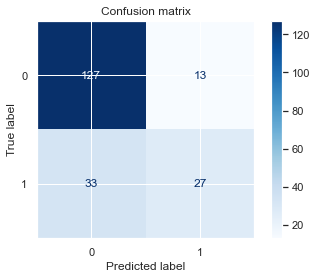

       Sensitivity  Specificity   Precision     Accuracy  
robust     0.91         0.45         0.68         0.77    
  base     0.86         0.50         0.61         0.76    


In [22]:
# Choice the coefficient w_i and give it to each columns
coef = {'high': 0.4}
col_coef = {col: coef[key] for key in type_col.keys() for col in type_col[key]}

# Calculate the weigth for every entries
weight_list = ([(col_coef[col]/X[col].unique().size + 
                 same[col]*(1 - col_coef[col])) for col in var_columns])
weight = weight_list[0]
for w in weight_list[1:]:
    weight *= w

logreg_robust = model.fit(alt_inds[X.columns], alt_inds.default, logreg__sample_weight=weight)
uti.mesure_clas_list([logreg_robust, logreg], X_test, y_test, ['robust', 'base'])

La matrice de confusion et les différentes métriques montrent que le nouveau modèle a des caractéristiques très proches du modèle initial. Nous cherchons à voir s'il est plus robuste que le modèle initial. Pour cela, on va calculer le nombre de personnes qui peuvent modifier leur classe (de 1 vers 0) en falsifiant les variables définies comme facilement falsifiables.

In [23]:
# Calculate the old probability without falsification and keep those that predict 1
old_proba = pd.Series(logreg_robust.predict_proba(X_test)[:, 1],
                     name='old_proba',
                     index=X_test.index)
X_default = pd.concat([X_test, old_proba], axis=1)[old_proba > 0.5]

# Generate all possible falsification and calculate probability for each
alt_inds_default = gen_all_ind(X_default, var_columns)
alt_inds_default['proba'] = logreg_robust.predict_proba(alt_inds_default[X.columns])[:, 1]

# For each individual get the minimum probability attainable with falsification
proba_min = alt_inds_default.groupby('index_old').apply(lambda df: min_proba(df))
X_default = X_default.assign(proba_min = proba_min.droplevel(1))

print('Default label : {}'.format(len(X_default)))
print('Change to no-default : {}'.format(len(X_default[X_default.proba_min < 0.5])))

40it [00:00, 186.63it/s]

Default label : 40
Change to no-default : 7


En associant une pondération de 0.4 à nos variables falsifiables et de 0 aux variables non falsifiables, on obtient après entraînement du modèle que seulement 7 individus peuvent changer de classe sur 40. En comparaison, le modèle initial autorisait 44 personnes sur 49 à modifier leur classe. On a donc un modèle bien plus robuste que le modèle initial.

Afin de rentrer dans les détails, on peut regarder l'impact d'attaques par évasion sur le score des individus.

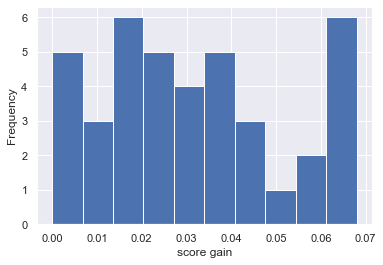

In [24]:
(X_default.old_proba - X_default.proba_min).plot.hist()
plt.ylabel('Frequency')
plt.xlabel('score gain')
plt.show()

Pour le modèle classique, on avait en moyenne une baisse de 0.4 sur le score d'un individu après une attaque par évasion. Dans le cas du nouveau modèle cette moyenne est divisée par 10 et le score des individus varie très peu lors de ce type d'attaque. Les variables falsifiables ont ainsi beaucoup moins d'impact sur la prédiction du modèle et ce dernier est devenu robuste contre les attaques d'évasion.

On peut maintenant étudier l'influence du coefficient de pondération associé (que l'on a précédemment fixé à 0.4) aux variables falsifiables sur la robustness du modèle.

In [25]:
def gen_reg_robust(proba=0.4, inds=alt_inds, X=X):
    # The coefficient w_i
    coef = {'high': proba}
    col_coef = {col: coef[key] for key in type_col.keys() for col in type_col[key]}

    # Calculate the weigth for every entries
    weight_list = ([(col_coef[col]/X[col].unique().size + 
                     same.loc[sub_alt_inds.index][col]*(1 - col_coef[col])) 
                                                        for col in var_columns])

    weight = weight_list[0]
    for w in weight_list[1:]:
        weight *= w

    logreg_robust = model.fit(inds[X.columns], inds.default, 
                              logreg__sample_weight=weight)
    
    # Keeping metrics on the model to see how the coefficient affects the classification
    y_pred = logreg_robust.predict(X_test)
    metrics = classification_report(y_test, 
                                    y_pred,
                                    output_dict=True)
    
    # Calculate the old probability without falsification and keep the 1s
    old_proba = pd.Series(logreg_robust.predict_proba(X_test)[:, 1],
                         name='old_proba',
                         index=X_test.index)
    X_default = pd.concat([X_test, old_proba], axis=1)[old_proba > 0.5]

    # Generate all possible falsification and calculate probability for each
    alt_inds_default = gen_all_ind(X_default, var_columns)
    alt_inds_default['proba'] = logreg_robust.predict_proba(alt_inds_default[X.columns])[:, 1]

    # For each individual get the minimum probability attainable with falsification
    proba_min = alt_inds_default.groupby('index_old').apply(lambda df: min_proba(df))
    X_default = X_default.assign(proba_min = proba_min.droplevel(1))

    return metrics, len(X_default), len(X_default[X_default.proba_min < 0.5])

In [26]:
n_same = 100
columns=['coef', 'n_ones', 'n_change', 
         'accuracy', 'sensitivity', 
         'specificity', 'precision']

if NEW:
    df_res = pd.DataFrame(columns=columns)

    for proba in np.linspace(0, 1, 20):
        for _ in range(n_same):
            idx_ind = np.random.choice(alt_inds.index_old.unique(), 600, 
                                       replace=False)
            idx = alt_inds.apply(lambda x: x.index_old in idx_ind, axis=1)
            sub_alt_inds = alt_inds[idx]
            try:
                metrics, n_ones, n_change = gen_reg_robust(proba, sub_alt_inds, 
                                                       X.loc[idx_ind])
                res = {'coef': proba,
                       'n_ones': n_ones,
                       'n_change': n_change,
                       'accuracy': metrics['accuracy'],
                       'sensitivity': metrics['0']['recall'],
                       'specificity': metrics['1']['recall'],
                       'precision': metrics['1']['precision']}
            
                df_res = df_res.append(res, ignore_index=True)
            except ValueError:
                print('error')
                
    np.savez_compressed(f'data/robustness/data_res.npz', df_res=df_res)
    
else:
    file = np.load(f'data/robustness/data_res.npz', allow_pickle=True)
    df_res = pd.DataFrame(file['df_res'], columns=columns)
    

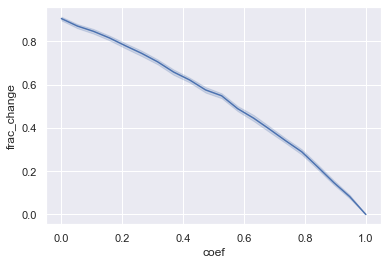

In [27]:
df_res['frac_change'] = df_res['n_change']/df_res['n_ones']

sns.lineplot(x='coef', y='frac_change', data=df_res)
plt.show()

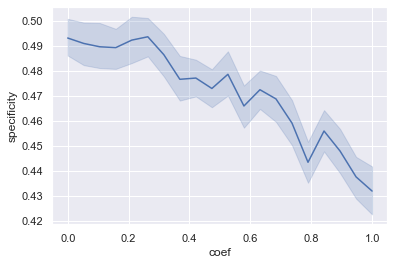

In [28]:
sns.lineplot(x='coef', y='specificity', data=df_res)
plt.show()

---
[MOD]

Les graphiques ci-dessus prouve bien l'efficacité de la méthode. On observe une baisse du nombre d'individus en mesure de changer la prédiction en modifiant les variables `purpose` et `personal_status`. Lorsque que le coefficient est à 1 on ne fait plus du tout confiance à ces deux variables donc il est logique de voir que l'évasion est totalement inefficace dans ce cas. 

En contrepartie de cette stabilité, on voit que la performance du modèle diminue avec l'augmentation du coefficient. On a tracé ici la `specificity` qui correspond à la fraction de labels 0 prédits correctement, ici la fraction de personnes ayant remboursé leur prêt et qui sont prédit comme capable de rembourser, sur la totalité des personnes qui sont prédit comme capables de rembourser.

Il est alors question de compromis entre performance et stabilité.

---

# Partie 3

## Les libraires pour la stabilité des modèles statistiques ne sont pas assez matures.

Les différentes implémentations des attaques et des méthodes de robustness (cf partie I et II) ont permis de constater certaines lacunes des différentes librairies existantes. Aucune des méthodes mises en œuvre dans la deuxième partie ne proviennent des librairies et ce pour deux raisons. La première est pédagogique, voir le détail de l’implémentation permet de comprendre les idées de celle-ci. La deuxième est le manque de méthodes correspondant à mon problème, un modèle de régression logistique avec des variables catégorielles. Cela peut s’expliquer par la présence de seulement deux librairies sur la stabilité des modèles : *Adverserial Robustness Toolbox* (ART), développé par IBM en 2019 et *AdvBox* développé par Baidu en 2020. Avec une majorité des exemples et de la documentation de *AdvBox* en chinois. Pour ce qui est des exemples de ART ils sont nombreux pour les différentes attaques mais plus rares pour les méthodes de défenses. À cela s’ajoute le manque d’échange sur les sites comme *stack overflow* avec seulement trois questions pour ART et aucune pour *AdvBox*. 
Pour espérer une adoption des méthodes de stabilité, il faut continuer le développement des librairies existantes. ART, la librairie plus avancée, rassemble dans un seul répertoire tout ce qu’il faut pour attaquer et défendre plusieurs aspects d’un modèle. 
Un très grand nombre d’outils, sans une méthode pour choisir les plus pertinentes, risque de décourager l’implémentation. Lorsque le besoin est clairement identifié et que l’on sait  quelle méthode on va utiliser et que celle-ci est implémentée, il est plutôt facile de la mettre en œuvre. Pour pallier ces problèmes et continuer de faciliter la tâche des développeurs, il faut continuer à investir du temps et de l’argent dans les outils pour couvrir le plus de cas possible mais en se concentrant sur les méthodes d’explication et de choix des modèles. Pour choisir au mieux les modèles on peut investir dans des méta analyses ou bien des études de cas dans les exemples des librairies qui soulignent les avantages et inconvénients des méthodes.

## Les libraires de stabilité sont à jour et bien documentés mais ne sont pas prête pour des cas industrielles. 
On retrouve les inconvénients des secteurs de recherche naissants qui n’ont pas encore quitté le monde académique. Les documentations sont pensées pour des développeurs ayant déjà une idée précise des enjeux, des méthodes et des solutions de la stabilité. Contrairement à la plupart des libraires utilisées dans ce rapport, l'ART contient des exemples d’implémentation très méthodiques et bien détaillés. Mais ils ne sont qu’une quinzaine (sur plus d'une centaine de méthodes) et ces exemples ne proposent pas d’explication sur les raisons du choix des méthodes présentées. On note tout de même que la stabilité est une problématique qui se visualise aisément dans certains cas comme la vision et il existe des outils comme https://art-demo.mybluemix.net/ qui permettent de comprendre visuellement les enjeux. Mais comme pour la *privacy* ces visualisations et la plupart des méthodes se concentrent sur des modèles avancés et complexes. 
La majorité des modèles utilisés en entreprise dont les enjeux de la stabilité sont importants, comme les modèles de pré-tris pour embauches, sont soit des modèles simples, soit des modèles plus complexes mais directement implémentés par des outils d’autoML.
Pour une adoption des méthodes et les rendre accessibles aux entreprises il faut des implémentations directement dans ces outils et se concentrer sur des solutions pour des modèles simples. L’impact d’une méthode sera d’autant plus importante qu’elle peut être mise en place facilement dans le monde réel. 
Il serait idéale de voir une appropriation industrielle du sujet avec la mise en place de produits simples, ceci couplé à une législation sur la notion de stabilité lorsque les modèles statistiques sont implémentés dans des domaines sensibles. Comme toujours la production de communication non scientifique pousse également à la discussion et à sensibiliser les industriels et les utilisateurs sur le sujet.

## Il existe un arbitrage important entre performance et stabilité
On a vu que la stabilité algorithmique requiert l’implémentation de méthodes autour du modèle choisie et qu’un modèle classique n’est pas robuste face à des exemples adverses. L’ajout de ces méthodes est donc nécessaire mais impactent les performances du modèle. Dans notre exemple de régression logistique l’augmentation de la stabilité n’a pas engendré une baisse drastique de l’*accuracy* mais des publications comme (https://arxiv.org/pdf/1805.12152.pdf) montrent qu’il existe une tension entre ces deux variables. De plus, l'ajout de méthodes augmente le temps d'entraînement et d’utilisation d’un modèle. Dans notre exemple, le temps d’entraînement du modèle sans stabilité est de 50ms et 38 des 40 personnes qui ont refusé peuvent modifier la prédiction. Lorsque l’on implémente notre méthode le temps d’entraînement passe à 6s mais cette fois-ci seulement 7 des 40 personnes on pu modifier leur prédiction.
L’inconvénient est qu’il n’y a pas de document non scientifique qui explique ces arbitrages et aide à la prise de décision. L'idéal serait des tableaux de comparaison entre les méthodes pour comprendre les différences entre chaque méthode. Cela passe également par la prise en main des outils et une adoption par les développeurs pour avoir un retour sur ce qui est important et ce sur quoi on peut faire des compromis avec la performance. On peut également imaginer que dans les communications scientifiques ces questions de compromis soient abordées plus régulièrement.
